In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchaudio import transforms
from matplotlib import pyplot as plt
from PIL import Image
#from joblib import Parallel, delayed  #multithreading 

In [2]:
# Definir una red neuronal simple
class Model_qm(nn.Module):
    def __init__(self):
        super(Model_qm, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 8)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [3]:
q_m_XOR = Model_qm()
state_dict_XOR = torch.load('q_m_XOR.pth')
q_m_XOR.load_state_dict(state_dict_XOR)

def q_m_XOR_diff(bits):
    return q_m_XOR(bits)

In [4]:
q_m_XNOR = Model_qm()
state_dict_XNOR = torch.load('q_m_XNOR.pth')
q_m_XNOR.load_state_dict(state_dict_XNOR)

def q_m_XNOR_diff(bits):
    return q_m_XNOR(bits)

In [5]:
def q_m_diff(input):
    output = torch.zeros((input.shape[0],9), dtype=torch.float32)
    all_ind_mask = torch.ones(input.shape[0], dtype=torch.bool)
    num_1 = (input > 0.5).sum(dim=1)
    #print(f"num_1:{num_1}")
    num_1_plus4_mask = (num_1 > 4) # mask donde la suma de 1 es mayor a 4
    #print(f"num_1_plus4_mask: {num_1_plus4_mask}")
    num_1_equal4_mask = (num_1 == 4) # mask donde la suma de 1 es 4
    #print(f"num_1_equal4_mask:{num_1_equal4_mask}")                      
    data0_equal0_mask = (input[:,0] == 0) # mask donde el primer valor de la entrada es 0
    #print(f"data0_equal0_mask:{data0_equal0_mask}")  
    intersect_ind_mask = (data0_equal0_mask & num_1_equal4_mask) # mask donde el primer valor de la entrada es 0 y la suma de 1 es 4
    #print(f"intersect_ind_mask 1:{intersect_ind_mask}")   
    intersect_ind_mask = (intersect_ind_mask | num_1_plus4_mask)  # mask donde: (el primer valor de la entrada es 0 y la suma de 1 es 4) OR (la suma es mayor a 4)
    #print(f"intersect_ind_mask 2:{intersect_ind_mask}")   
    intersect_ind = intersect_ind_mask.nonzero().squeeze()  # posiciones donde: (el primer valor de la entrada es 0 y la suma de 1 es 4) OR (la suma es mayor a 4)
    #print(f"intersect_ind:{intersect_ind}")   
    rest_ind = (intersect_ind_mask != all_ind_mask).nonzero().squeeze() #resto de indices que no cumplen condiciones anteriores
    #print(f"rest_ind:{rest_ind}")

    output[intersect_ind,:8] = q_m_XNOR_diff(input[intersect_ind,:])
    output[intersect_ind,8] = 0
    output[rest_ind,:8] = q_m_XOR_diff(input[rest_ind,:])
    output[rest_ind,8] = 1

    return output

In [6]:
def TMDS_diff(pixel_column_bits,cnt_column):
    bits_inversos = torch.flip(pixel_column_bits, dims = (1,))  #ahora es en la dim = 1 y no 0
    q_m = q_m_diff(bits_inversos)
    #print(f"qm_diff:{torch.round(q_m)}")
    output = torch.zeros((pixel_column_bits.shape[0],10),dtype=torch.float32)
    num_1 = (q_m[:,:8] > 0.5).sum(dim = 1)
    num_0 = (q_m[:,:8] < 0.5).sum(dim = 1)
    #print(f"num1:{num_1}")
    #print(f"num0:{num_0}")
    all_ind_mask = torch.ones(q_m.shape[0], dtype=torch.bool)
    IndE_mask = (cnt_column == 0) | (num_1 == num_0)
    #print(f"IndE_mask:{IndE_mask}")
    IndE_ind = ((cnt_column == 0) | (num_1 == num_0)).nonzero().squeeze()
    #print(f"IndE_ind:{IndE_ind}")
    IndC_mask = ((cnt_column > 0) & (num_1 > num_0)) | ((cnt_column < 0) & (num_0 > num_1))
    #print(f"IndC_mask:{IndC_mask}")
    Neg_q = 1 - q_m
    #print(f"Neg_qm_diff:{torch.round(Neg_q)}")
    IndE_and_q_m_0 = ((IndE_mask) & (q_m[:,8] < 0.5)).nonzero().squeeze()
    #print(f"IndE_and_q_m_0:{IndE_and_q_m_0}")
    IndE_and_q_m_1 = ((IndE_mask) & (q_m[:,8] > 0.5)).nonzero().squeeze()
    #print(f"IndE_and_q_m_1:{IndE_and_q_m_1}")
    NotIndE_and_IndC = (torch.logical_not(IndE_mask) & IndC_mask).nonzero().squeeze()
    #print(f"NotIndE_and_IndC:{NotIndE_and_IndC}")
    NotIndE_and_NotIndC = (torch.logical_not(IndE_mask) & torch.logical_not(IndC_mask)).nonzero().squeeze()
    #print(f"NotIndE_and_NotIndC:{NotIndE_and_NotIndC}")
    q_m_mask = (IndE_mask & (q_m[:,8] > 0.5)) | (torch.logical_not(IndC_mask) & torch.logical_not(IndE_mask))
    #print(f"q_m_mask:{q_m_mask}")
    q_m_ind = ((IndE_mask & (q_m[:,8] > 0.5)) | (torch.logical_not(IndC_mask) & torch.logical_not(IndE_mask))).nonzero().squeeze()
    #print(f"q_m_ind:{q_m_ind}")
    Neg_q_ind = (q_m_mask != all_ind_mask).nonzero().squeeze()
    #print(f"Neg_q_ind:{Neg_q_ind}")
    output[q_m_ind,:8] = q_m[q_m_ind,:8]
    output[Neg_q_ind,:8] = Neg_q[Neg_q_ind,:8]
    output[:,8] = q_m[:,8]
    output[IndE_ind,9] = Neg_q[IndE_ind,8]
    new_cnt = cnt_column.clone()
    new_cnt[IndE_and_q_m_0] = cnt_column[IndE_and_q_m_0] + num_0[IndE_and_q_m_0] - num_1[IndE_and_q_m_0]
    new_cnt[IndE_and_q_m_1] = cnt_column[IndE_and_q_m_1] + num_1[IndE_and_q_m_1] - num_0[IndE_and_q_m_1]
    #print(f"new_cnt:{new_cnt}")
    output[NotIndE_and_IndC,9] = 1
    new_cnt[NotIndE_and_IndC] = cnt_column[NotIndE_and_IndC] + 2 * q_m[NotIndE_and_IndC,8] + num_0[NotIndE_and_IndC] - num_1[NotIndE_and_IndC]
    #print(f"new_cnt:{new_cnt}")
    output[NotIndE_and_NotIndC,9] = 0
    new_cnt[NotIndE_and_NotIndC] = cnt_column[NotIndE_and_NotIndC] - 2 * Neg_q[NotIndE_and_NotIndC,8] + num_1[NotIndE_and_NotIndC] - num_0[NotIndE_and_NotIndC]
    #print(f"new_cnt:{new_cnt}")

    return output,new_cnt

In [7]:
def sigmoid(x):
    output = torch.zeros_like(x)
    ind_greater_0 = (x >= 0).nonzero().squeeze()
    ind_smaller_0 = (x < 0).nonzero().squeeze()
    output[ind_greater_0] = 1 / (1 + torch.exp(-x[ind_greater_0]))
    output[ind_smaller_0] = torch.exp(x[ind_smaller_0]) / (1 + torch.exp(x[ind_smaller_0]))

    return output

def Pixel2Bit_diff(pixel):
    pixel_aux = pixel.clone()
    output = torch.zeros((pixel.shape[0],8), dtype= torch.float32)
    for i in range(1,9):
        output[:,i-1] = sigmoid(10*(pixel_aux-2**(8-i)+0.5))  # 0.5 para ajustar la sigmoidal
        ind_pixel_greater2Pow = (pixel_aux >= 2**(8-i)).nonzero().squeeze()
        pixel_aux[ind_pixel_greater2Pow] = pixel_aux[ind_pixel_greater2Pow] - 2**(8-i)
    return output


In [8]:
def visualize_TMDS(img):
    rows = img.shape[0]
    columns = img.shape[1]

    pow_mat = 2**np.arange(10)
    pow_mat = pow_mat[np.newaxis,:]
    pow_mat = np.repeat(pow_mat,rows,axis=0)

    cnt_column = torch.zeros(rows)
    pixels_column = torch.zeros(rows)
    pixel_column_bits = torch.zeros((rows,8),dtype = torch.float32)
    bits_cod_column =  torch.zeros((rows,10), dtype = torch.float32)
    img_cod = np.zeros((rows,columns),dtype=np.float32)
    for j in range(columns):
        pixels_column = img[:,j]
        pixel_column_bits = Pixel2Bit_diff(pixels_column)
        bits_cod_column,cnt_column = TMDS_diff(pixel_column_bits, cnt_column)
        img_cod[:,j] = np.sum(bits_cod_column.detach().numpy().astype('uint16') * pow_mat,axis=1)
    return img_cod

In [9]:
def line_degradation(I_line, h_total=1800, v_total=1000, N_harmonic=3, sdr_rate = 50e6, fps=60):
    """  
    Given an image line bitstream (fs=bitrate), it performs the capture effect of HDMI with
    the pair antenna-SDR (using the specified SDR sample rate, resolution setup and pixel frequency harmonic)
    Returns the captured signal at SDR's sample rate and horizontal pixel resolution

    Inputs:
    I_line (torch tensor): input image bitstream line to perform capture degradation
    h_total (int): horizontal resolution (pixels)
    v_total (int): vertical resolution (pixels)
    N_harmonic (int): number of pixel frequency harmonic
    sdr_rate (float): sampling rate of SDR

    Output:
    I_line (complex torch tensor):  degradeted image bitstream line with SDR resampling with 
                                    horizontal image resolution
    """
    I_line_complex = I_line.clone()

    # Compute pixelrate and bitrate
    px_rate = h_total*v_total*fps
    bit_rate = 10*px_rate

    # Continuous samples (interpolate)
    interpolator = int(np.ceil(N_harmonic/5)) # Condition for sampling rate and
    sample_rate = interpolator*bit_rate
    Nsamples = 10*h_total
        
    # Continuous time array
    t_continuous = torch.arange(Nsamples)/sample_rate

    # AM modulation frequency according to pixel harmonic
    harm = N_harmonic*px_rate

    # Harmonic oscilator (including frequency and phase error)
    baseband_exponential = torch.exp(2j*np.pi*harm*t_continuous)
    # Baseband representation
    I_line_baseband = I_line_complex * baseband_exponential

    # AM modulation and SDR sampling
    resampler = transforms.Resample(sample_rate, sdr_rate)

    # Reshape signal to the image size
    I_line_out = nn.functional.interpolate(resampler(torch.real(I_line_baseband)),h_total) + 1j*nn.functional.interpolate(resampler(torch.imag(I_line_baseband)),h_total)
    

    return I_line_out

In [10]:
def forward(img):
    rows = img.shape[0]
    columns = img.shape[1]
    cnt_column = torch.zeros(rows)
    pixels_column = torch.zeros(rows)
    pixel_column_bits = torch.zeros((rows,8),dtype = torch.float32)
    bits_cod_column =  torch.zeros((rows,10), dtype = torch.float32)
    img_cod = torch.zeros((rows,columns*10),dtype = torch.complex64)
    img_out = torch.zeros((rows,columns),dtype=torch.complex64)
    for j in range(columns):
        pixels_column = img[:,j]
        pixel_column_bits = Pixel2Bit_diff(pixels_column)
        bits_cod_column,cnt_column = TMDS_diff(pixel_column_bits, cnt_column)
        img_cod[:,j*10:(j+1)*10] = bits_cod_column
    for i in range(rows):
        img_out[i,:] = line_degradation(img_cod[i,:].unsqueeze(0).unsqueeze(0), h_total=columns, v_total=rows, N_harmonic=3, sdr_rate = 50e6, fps=60)
    return img_out

In [11]:
image_path = '../imagenes/VAMO.png'
img = np.asarray(Image.open(image_path))[:,:,0] #solo canal rojo
img_slice = torch.tensor(img, dtype=torch.float32, requires_grad=True)
imagen = forward(img_slice)

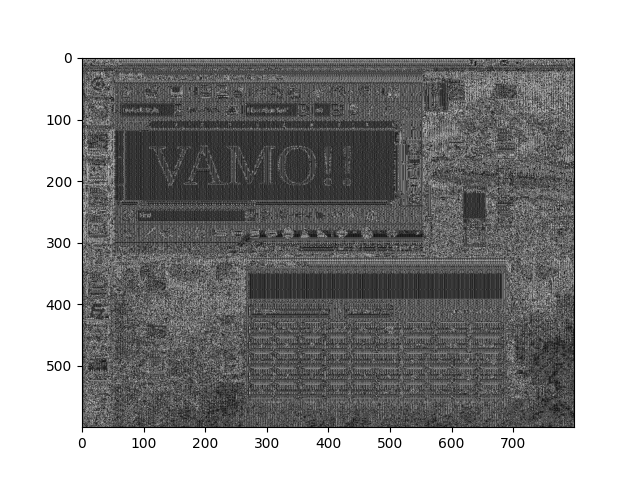

In [22]:
%matplotlib widget
plt.figure()
plt.imshow(np.abs(imagen.detach().numpy()),cmap='gray')
plt.show()

In [13]:
def uint8_to_binarray(integer):
  """Convert integer into fixed-length 8-bit binary array. LSB in [0].
  Extended and modified code from https://github.com/projf/display_controller/blob/master/model/tmds.py
  """

  b_array = [int(i) for i in reversed(bin(integer)[2:])]
  b_array += [0]*(8-len(b_array))
  return b_array


def binarray_to_uint(binarray):
	
  array = binarray[::-1]
  num = array[0]
  for n in range(1,len(binarray)):
    num = (num << 1) + array[n]

  return num

def TMDS_pixel (D,cnt=0):
  """8bit pixel TMDS coding

  Inputs: 
  - pix: 8-bit pixel
  - cnt: 0's and 1's balance. Default in 0 (balanced)

  Outputs:
  - pix_out: TDMS coded 16-bit pixel (only 10 useful)
  - cnt: 0's and 1's balance updated with new pixel coding

  """ 
  # Convert 8-bit pixel to binary list D
  #D = uint8_to_binarray(pix)

  # Initialize output q
  qm = [D[0]]

  # 1's unbalanced condition at current pixel
  N1_D = np.sum(D)

  if N1_D>4 or (N1_D==4 and not(D[0])):

    # XNOR of consecutive bits
    for k in range(1,8):
      qm.append( not(qm[k-1] ^ D[k]) )
    qm.append(0)

  else:
    # XOR of consecutive bits
    for k in range(1,8):
      qm.append( qm[k-1] ^ D[k] )
    qm.append(1)

  # Initialize output qout
  qout = qm.copy()

  # Unbalanced condition with previous and current pixels
  N1_qm = np.sum(qm[:8])
  N0_qm = 8 - N1_qm

  if cnt==0 or N1_qm==4:

    qout.append(not(qm[8]))
    qout[8] = qm[8]
    qout[:8]=qm[:8] if qm[8] else np.logical_not(qm[:8])

    if not(qm[8]):
      cnt += N0_qm - N1_qm 
    else:
      cnt += N1_qm - N0_qm 

  else:

    if (cnt>0 and N1_qm>4) or (cnt<0 and N1_qm<4):
      qout.append(1)
      qout[8] = qm[8]
      qout[:8] = np.logical_not(qm[:8])
      cnt += 2*qm[8] + N0_qm - N1_qm
    else:
      qout.append(0)
      qout[8] = qm[8]
      qout[:8] = qm[:8]
      cnt += -2*(not(qm[8])) + N1_qm - N0_qm

  return qout, cnt

In [14]:
import itertools
enteros = range(-9, 10)
binarios = [list(map(int, list(bin(i)[2:].zfill(8)))) for i in range(256)]

combinaciones = list(itertools.product(binarios, enteros))

X = np.array([list(comb[0]) + [comb[1]] for comb in combinaciones])
X_t = torch.tensor(X,dtype=torch.float32)

print(X)
print(X_t)
print(X.shape)
print(X_t.shape)

[[ 0  0  0 ...  0  0 -9]
 [ 0  0  0 ...  0  0 -8]
 [ 0  0  0 ...  0  0 -7]
 ...
 [ 1  1  1 ...  1  1  7]
 [ 1  1  1 ...  1  1  8]
 [ 1  1  1 ...  1  1  9]]
tensor([[ 0.,  0.,  0.,  ...,  0.,  0., -9.],
        [ 0.,  0.,  0.,  ...,  0.,  0., -8.],
        [ 0.,  0.,  0.,  ...,  0.,  0., -7.],
        ...,
        [ 1.,  1.,  1.,  ...,  1.,  1.,  7.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  8.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  9.]])
(4864, 9)
torch.Size([4864, 9])


In [15]:
errores = 0
bits_diff = torch.zeros((X.shape[0],10))
cnt_diff = torch.zeros((X.shape[0],1))
bits_diff,cnt_diff = TMDS_diff(X_t[:,:8],X_t[:,8])
for i in range(X.shape[0]):
    bits_posta,cnt_posta = TMDS_pixel(X[i,:8][::-1],X[i,8])
    bits_posta = np.array(bits_posta)
    if not(np.array_equal(np.round(bits_diff[i,:].detach().numpy()), bits_posta[:10])) and cnt_posta != np.round(cnt_diff[i].detach().numpy()):
        errores = errores + 1
        print(f"input: {X[i,:8]} cnt:{X[i,8]}")
        print(f"diff:{np.round(bits_diff[i,:].detach().numpy())} cnt diff:{cnt_diff[i].detach().numpy()}")
        print(f"posta:{bits_posta},cnt:{cnt_posta}")
        print(f"\n\n")
print(errores)

0
